In [99]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import classification as classify
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

data = classify.load_data("data_for_student_case.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
pdata = classify.pre_process(data)
classify.describe_data(pdata)

Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%



,issuercountrycode,bin,amount,shoppercountrycode,simple_journal,mail_id,ip_id,card_id,txvariantcode_electron,txvariantcode_mc,...,shopperinteraction_Ecommerce,shopperinteraction_POS,cvcresponsecode_0,cvcresponsecode_1,cvcresponsecode_2,cvcresponsecode_3,accountcode_APACAccount,accountcode_MexicoAccount,accountcode_SwedenAccount,accountcode_UKAccount
0,76.0,530056.0,64800.0,98.0,1.0,187702.0,7386.0,73358.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,76.0,547046.0,44900.0,98.0,1.0,834.0,194109.0,44739.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,76.0,528843.0,149900.0,98.0,1.0,119287.0,189655.0,122802.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,76.0,547146.0,109900.0,98.0,1.0,173561.0,8254.0,70712.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,76.0,477291.0,89900.0,98.0,1.0,70647.0,196247.0,208481.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [103]:
random_state=13
under_sampling_rate=0.0045
over_sampling_rate=0.125
splits = 10
print_tree = False
print_iterations = False

# Get feature vector and truth vector from dataset
X, y = classify.get_X_y(pdata)

# cv = KFold(n_splits=splits, shuffle=True)
cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)

# Initialize variables
tp_wb_total = []
tp_bb_total = []
fp_wb_total = []
fp_bb_total = []
feature_importance_wb = np.zeros(pdata.shape[1])
feature_importance_bb = np.zeros(pdata.shape[1])
iteration = 0

for train_index, test_index in cv.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    # Undersampling non-fraud class
    under_sampling = RandomUnderSampler(sampling_strategy=under_sampling_rate)
    X_train, y_train = under_sampling.fit_sample(X_train,y_train)
    
    # SMOTE Re-sampling
    sm = SMOTE(sampling_strategy=over_sampling_rate, random_state=random_state)

    X_train, y_train = sm.fit_sample(X_train, y_train)

    # Decision Tree classifer (White-Box)
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    tp_wb_total.append(TP)
    fp_wb_total.append(FP)
    
    # Collect importances per feature
    importances = clf.feature_importances_
    for i in range(len(X_train.columns)):
        feature_importance_wb[i] += importances[i]

    # Decision Tree Decider
    if print_tree:
        plt.style.use('dark_background')  
        mpl.rcParams['text.color'] = 'black'
    
        fig, ax = plt.subplots(dpi=600)
        tree.plot_tree(clf.fit(X_test,y_test),max_depth=10,feature_names = X_train.columns, class_names=['Non-fraud', 'Fraud'],filled = True, rotate=True, ax=ax)
        fig.savefig('tree-'+str(iteration)+'.png')

    # RandomForest Classifier (Black-box)
    clf = RandomForestClassifier(random_state=random_state, n_estimators=50,max_depth=30,min_samples_leaf=5,min_samples_split=12,n_jobs=2)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    importances = clf.feature_importances_
    for i in range(len(X_train.columns)):
        feature_importance_bb[i] += importances[i]

    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    tp_bb_total.append(TP)
    fp_bb_total.append(FP)
    
    if print_iterations:
        print(iteration, len(y_train[y_train==0]),len(y_train[y_train==1]), TP, FP)
        
    iteration += 1 
    
print("White-box:", f"TP: {np.sum(tp_wb_total)}", f"FP: {np.sum(fp_wb_total)}")
print("Black-box:", f"TP: {np.sum(tp_bb_total)}", f"FP: {np.sum(fp_bb_total)}")

White-box: TP: 101 FP: 1689
Black-box: TP: 105 FP: 1055


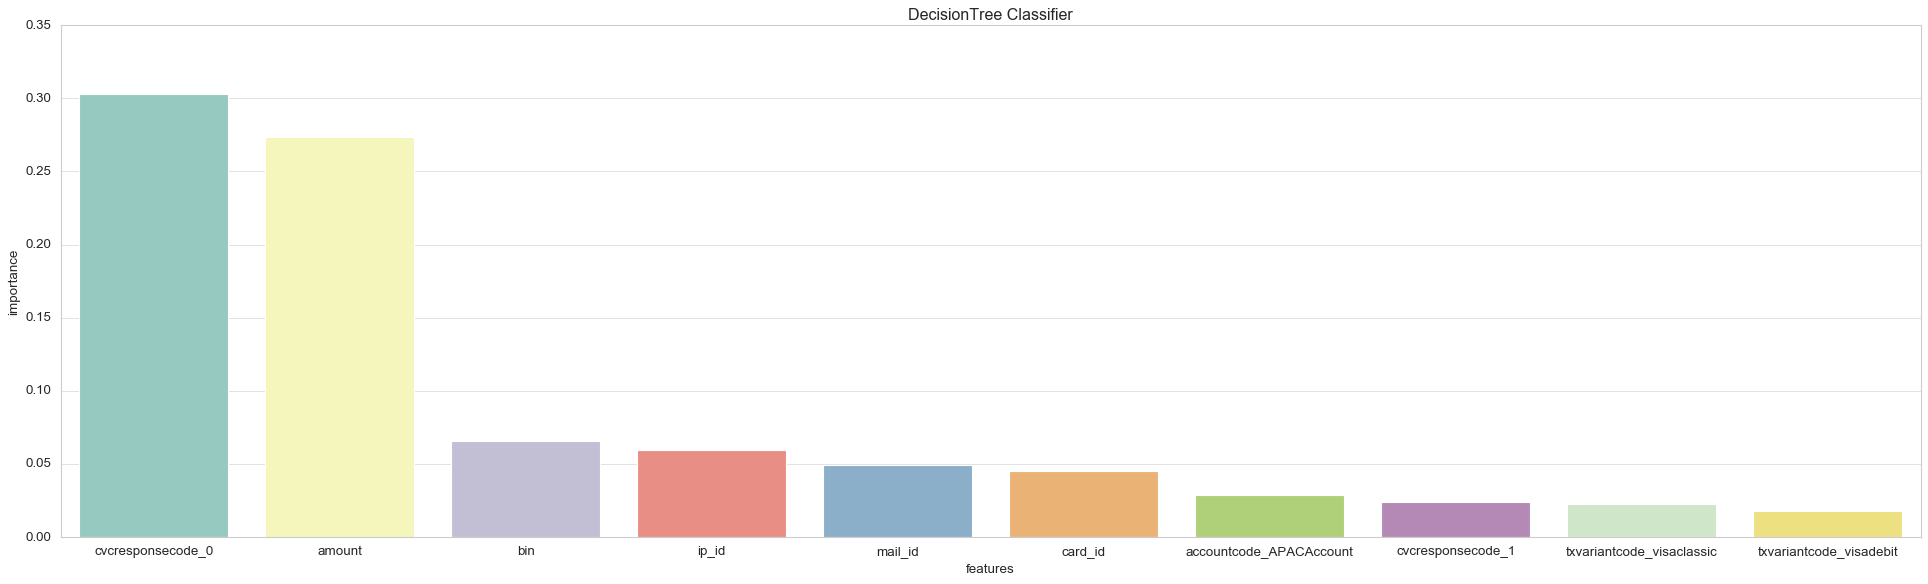

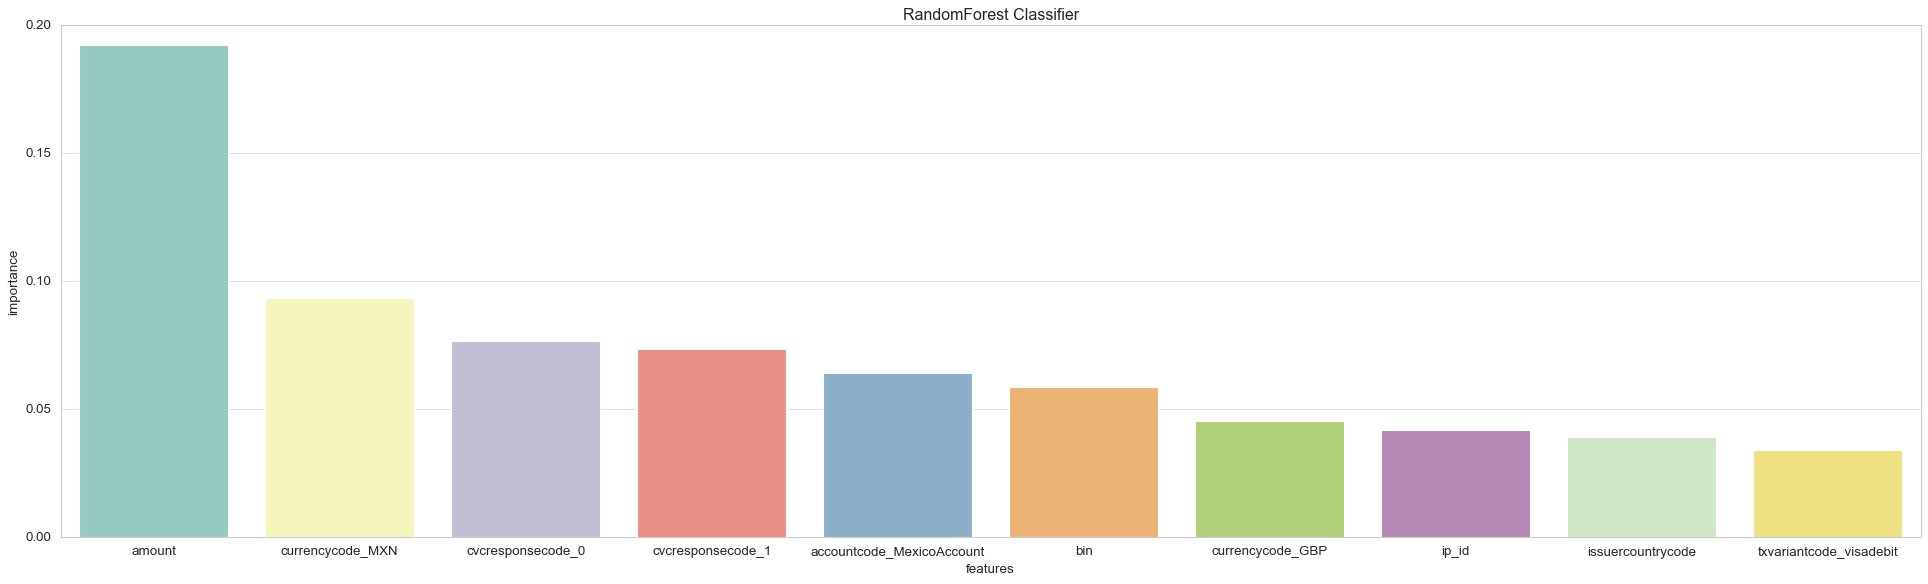

In [102]:
# Plot feature importances
algs = ["DecisionTree Classifier","RandomForest Classifier"]

for item in algs:
    features = X_train.columns.values
    
    if item == "DecisionTree Classifier":
        feat_imp = feature_importance_wb[0:len(features)-1]
    else:
        feat_imp = feature_importance_bb[0:len(features)-1]

    idx = np.argsort(feat_imp)
    imp = np.flip(np.array(feat_imp)[idx])
    imp = [float(i)/sum(imp) for i in imp]
    features = np.flip(np.array(features)[idx])

    df = pd.DataFrame(list(zip(features,imp)), columns=['features','importance'])

    sns.set_style('whitegrid')
    f, ax = plt.subplots(1,figsize = (30,8))
    ax = sns.barplot(x=df[:10].features,y=df[:10].importance)
    ax.set_title(item)
    plt.show()